### Colocalization analysis - preprocessing and segmentation

In [1]:
import czifile
from skimage import img_as_ubyte
from skimage.io import imsave
from PIL import Image

from matplotlib import pyplot as plt

from skimage.io import imread

from cellpose import models,io
import numpy as np
import pandas as pd

objc[826]: Class QMacAutoReleasePoolTracker is implemented in both /Users/jreinis/miniconda3/envs/test/lib/libQt5Core.5.15.2.dylib (0x182d67388) and /Users/jreinis/miniconda3/envs/test/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x190afb198). One of the two will be used. Which one is undefined.
objc[826]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/jreinis/miniconda3/envs/test/lib/libQt5Core.5.15.2.dylib (0x182d67400) and /Users/jreinis/miniconda3/envs/test/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x190afb210). One of the two will be used. Which one is undefined.
objc[826]: Class KeyValueObserver is implemented in both /Users/jreinis/miniconda3/envs/test/lib/libQt5Core.5.15.2.dylib (0x182d67428) and /Users/jreinis/miniconda3/envs/test/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x190afb238). One of the two will b

In [2]:
def renumber_mask(mask):
    mask_renumbered = np.zeros(shape=mask.shape, dtype="uint16")
    labels = np.unique(mask)
  
    # renumber the objects, keep order (e.g. 1,2,4,5 -> 1,2,3,4)
    for i, label in enumerate(labels):
        mask_renumbered[mask == label] = i
    return mask_renumbered

In [3]:
# load a stack saved as czi, calculate and return the max intensity Z projection
def load_czi_max_intensity_z_proj(czi_path):
    # single image expected, mutliple channels and planes
    imgs = czifile.imread(czi_path)[0,0,:,:,:,:,0]
    # reshape to (plane, height, width, channel) tensor
    imgs = np.moveaxis(imgs, 0, -1)
    # calculate the projection by simply taking the maximum across the 0 axis (=z)
    proj = np.max(imgs, axis=0)

    return proj

In [4]:
# remove objects from the first segmentation mask that overlap with mitotic cell objects from the second mask
def remove_mitotic_cells(mask, mask_mito, colormap,show=False):
    # remove all overlapping objects from main mask
    to_remove = np.unique(mask[mask_mito != 0])
    new_mask = mask.copy()
    for obj in to_remove:
        new_mask[mask == obj] = 0
    if show:
        show_n_images(colormap[mask], colormap[mask_mito], colormap[new_mask])
    return new_mask

In [5]:
# also include manual mask for mitotic cells, order of input channels can be changed 
def preprocess_czi_v2(czi_paths, mask_paths, colormap_path, reorder, diameter=125, output_folder=None):
    # load czi file - use maximum intensity z projection and reorder channels if necessary 
    imgs = [load_czi_max_intensity_z_proj(path)[...,reorder] for path in czi_paths]
    # load manually segmented mitotic cells
    masks_mito = [imread(mask_path) for mask_path in masks_paths]

    # nuclear channel is always the third - use for segmentation
    imgs_DAPI = [img[...,2] for img in imgs]
    # segment nuclei with Cellpose nuclear model run on DAPI channel
    model = models.Cellpose(model_type='nuclei')
    masks, flows, styles, diams = model.eval(imgs_DAPI, diameter=125, channels=[0,0], resample=True)
    colormap = np.load(colormap_path)[...,:-1]
    
    # mask without mitotic cells
    masks_nomito = [remove_mitotic_cells(mask, mask_mito, colormap) for mask, mask_mito in zip(masks, masks_mito)]
    # renumber
    masks_nomito = [renumber_mask(mask) for mask in masks_nomito]
    masks_mito = [renumber_mask(mask) for mask in masks_mito]
    
    # color visualization of the segmented cells, rescale to uint8
    masks_color = [img_as_ubyte(colormap[mask]) for mask in masks]
    masks_mito_color = [img_as_ubyte(colormap[mask]) for mask in masks_mito]
    masks_nomito_color = [img_as_ubyte(colormap[mask]) for mask in masks_nomito]

    # convert single-channel DAPI images to RGB so that they can be concatenated with other RGB images for overview image
    imgs_DAPI_rgb = [np.stack([img[...,2] for i in range(3)], axis=-1) for img in imgs]
    # create a stitched image of the 3 views (color overlay, DAPI channel, colored segmentation) for each image
    inspect_imgs = [np.concatenate([rgb, DAPI, mask, mask_mito, mask_nomito], axis=1) for rgb, DAPI, mask, mask_mito, mask_nomito in zip(imgs, imgs_DAPI_rgb, masks_color, masks_mito_color, masks_nomito_color)]
    
    # add white lines to inspection img for separation
    inspect_imgs = [img.copy() for img in inspect_imgs]
    for img in inspect_imgs:
        for x in range(0, img.shape[1], 1024):
            img[:,x-3:x,:] = 255
    
    # save the results
    if output_folder:
        for img, mask_mito, mask_nomito, inspect, czi_path in zip(imgs, masks_mito, masks_nomito, inspect_imgs, czi_paths):
            # get filenames and add them to the desired output folder
            savepath = f'{output_folder}/{czi_path.split("/")[-1].replace(".czi", "")}'
            # save channel overlay and each channel as greyscale image
            imsave(f"{savepath}.png", img)
            imsave(f"{savepath}_ch0_SRRM2.png", img[...,0])
            imsave(f"{savepath}_ch1_SMNDC1.png", img[...,1])
            imsave(f"{savepath}_ch2_DAPI.png", img[...,2])
            # save segmentation masks - needs to be done via PIL so that it doesn't break CellProfiler downstream
            # first the "raw" cellpose segmentation
            Image.fromarray(mask_mito).save(f"{savepath}_segmented_mitotic.png")
            # then the processed with mitotic cells filtered out
            Image.fromarray(mask_nomito).save(f"{savepath}_segmented_no_mitotic.png")           
            # save inspection image
            imsave(f"{savepath}_preprocessing_overview.png", inspect)
    
    return imgs, masks, inspect_imgs

### Config

In [6]:
zstacks_paths = [
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack1.czi",
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack2.czi",
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack3.czi",
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack4.czi",
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack5.czi",
    "/Users/jreinis/Downloads/2023_02_09/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack6.czi",
]


masks_paths = [
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack1_segmented_mitotic.png",
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack2_segmented_mitotic.png",
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack3_segmented_mitotic.png",
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack4_segmented_mitotic.png",
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack5_segmented_mitotic.png",
    "/Users/jreinis/Downloads/2023_02_09/manual_segmentation/20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack6_segmented_mitotic.png",
]

output_folder = "/Users/jreinis/Downloads/2023_02_09/processed"


colormap_path = "/Users/jreinis/Main/stage_1_segment_identify/cellprofiler_pipelines/2022-03-18-glasbey_light.npy"
colormap = np.load(colormap_path)

diameter = 125

# reversed order of channels - needs to be reordered for CellProfiler
channels_mapping = [
    (0,2, "DAPI"),
    (1,0, "SRRM2"),
    (2,1, "SMNDC1")
]

In [7]:
channels_mapping = pd.DataFrame(channels_mapping, columns=["map_from", "map_to", "name"]).sort_values("map_to")
channels_reorder = channels_mapping["map_from"].to_list()
channels_mapping

,map_from,map_to,name
1,1,0,SRRM2
2,2,1,SMNDC1
0,0,2,DAPI


### Run the analysis

In [8]:
%%time
imgs, masks, inspect_imgs = preprocess_czi_v2(zstacks_paths, masks_paths, colormap_path, channels_reorder, diameter, output_folder)

CPU times: user 1min 33s, sys: 9.51 s, total: 1min 42s
Wall time: 1min 36s


### Inspect the results

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack1.czi


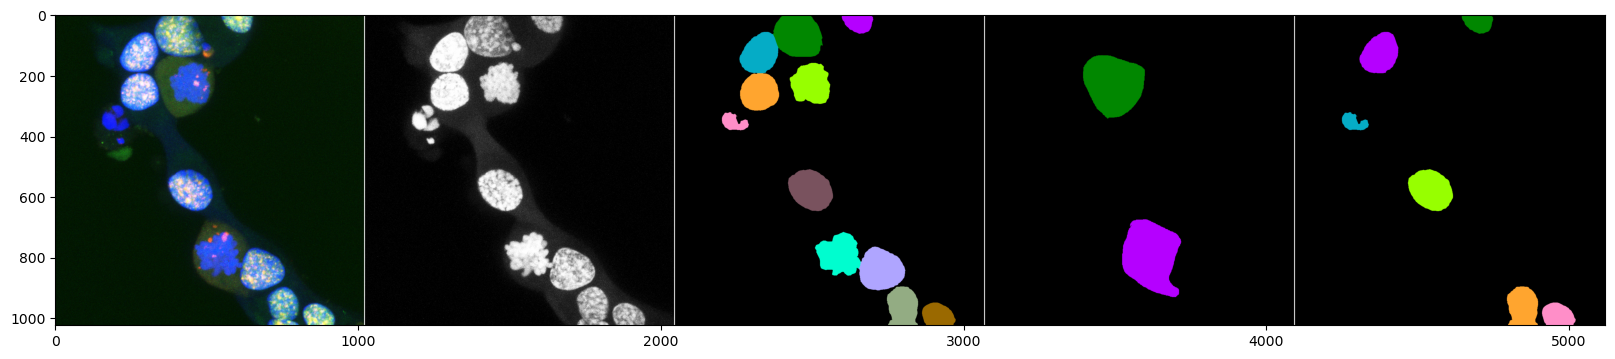

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack2.czi


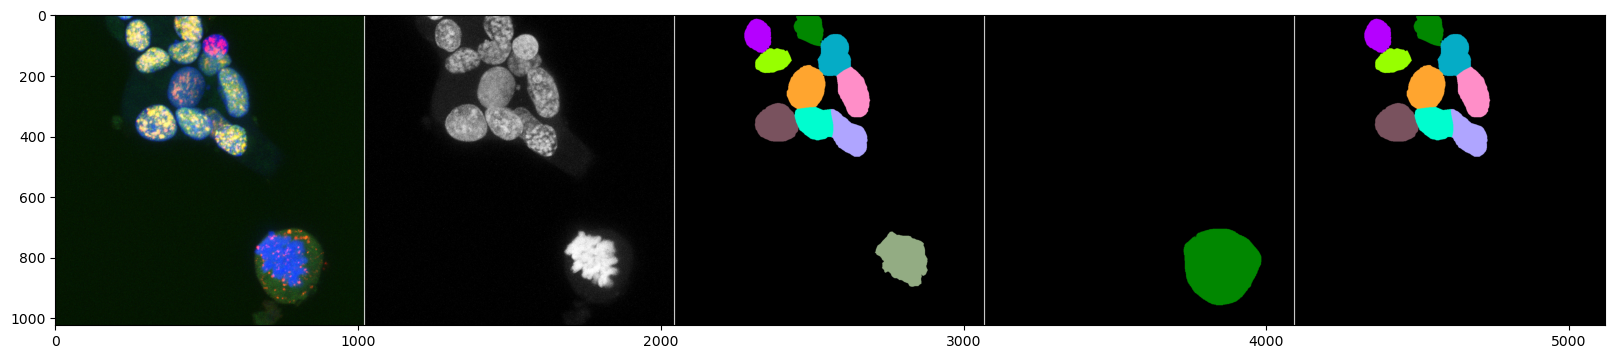

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack3.czi


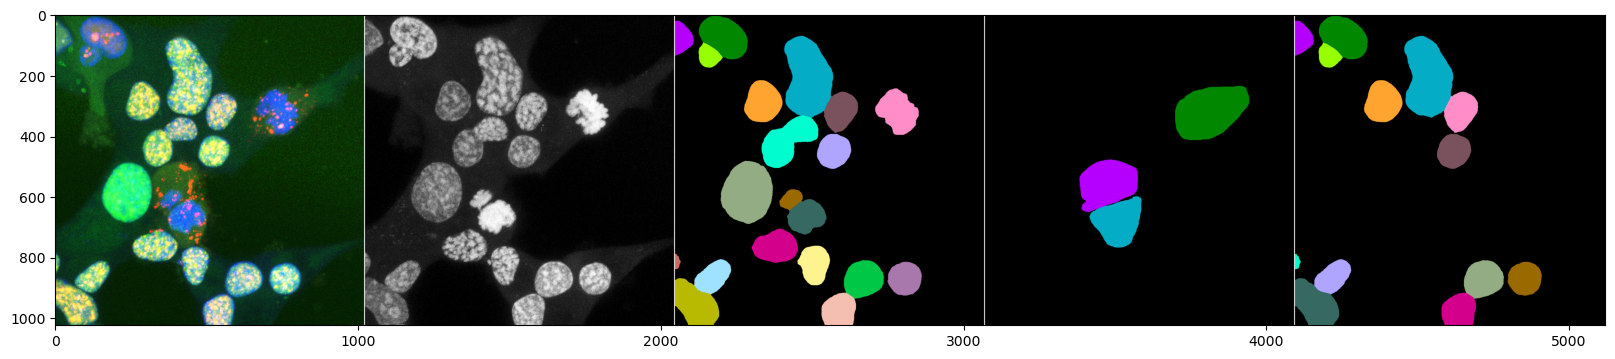

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack4.czi


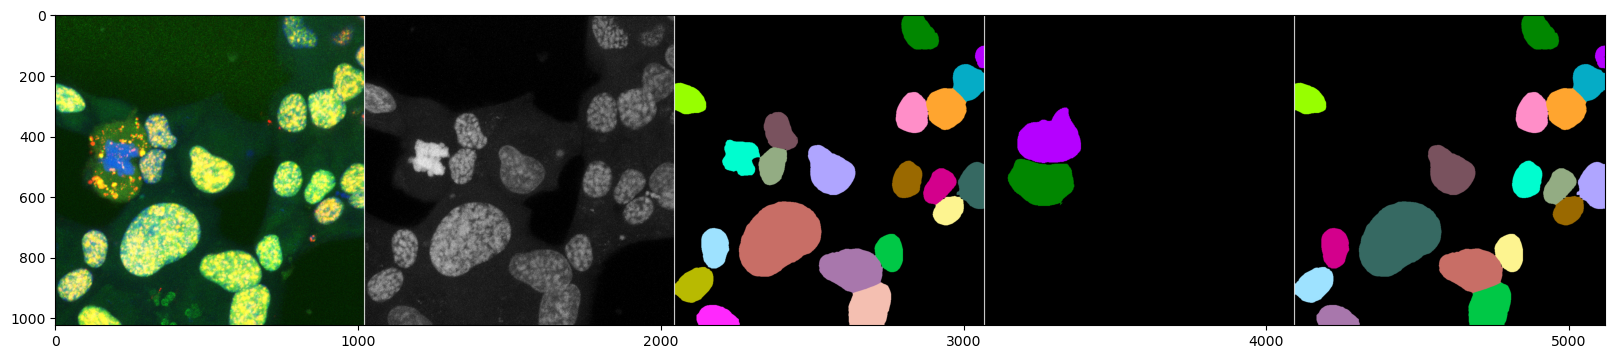

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack5.czi


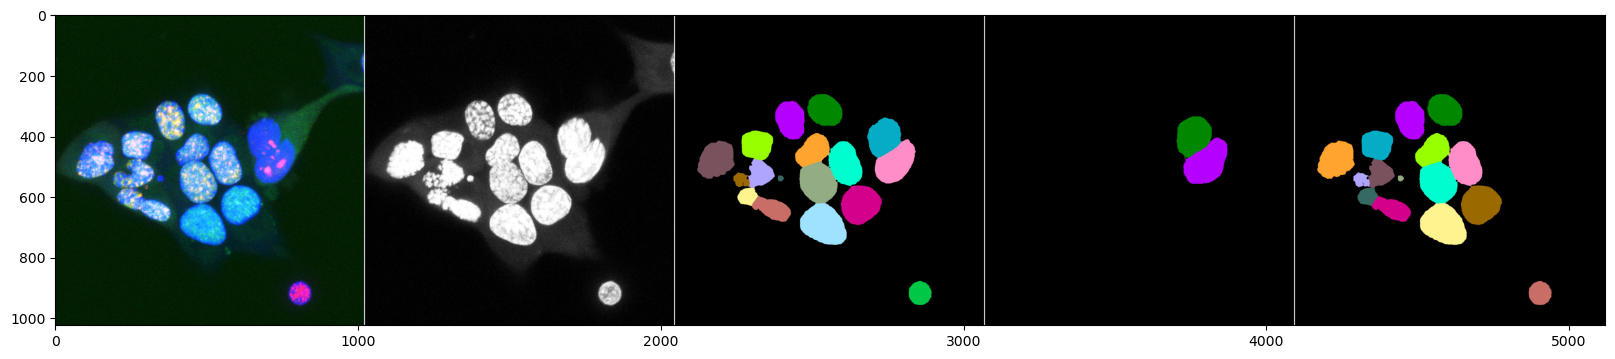

20230209_aTC1-live_DRAQ5_SMNDC1-GFP_SRRM2-RFP_zstack6.czi


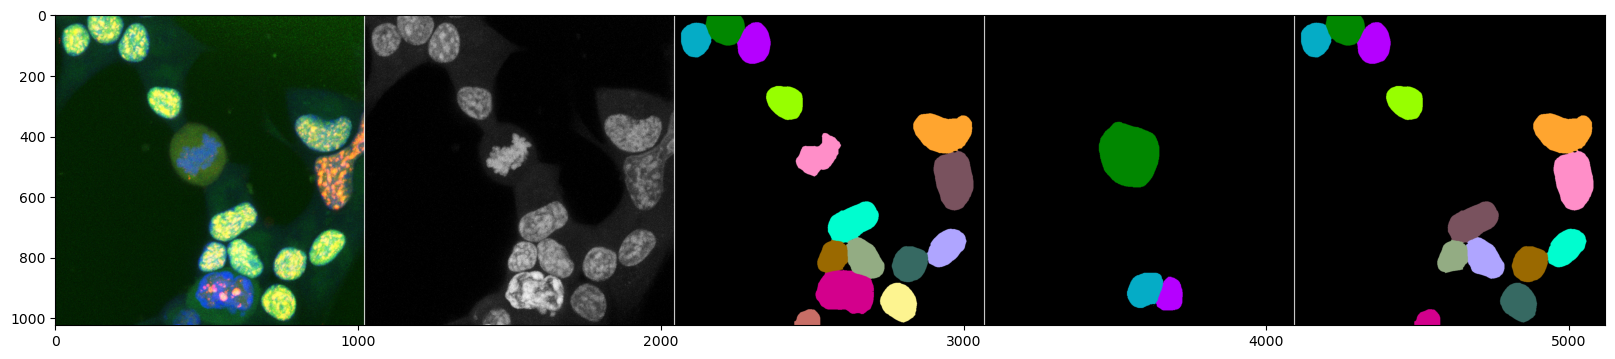

In [9]:
for img, name in zip(inspect_imgs, [x.split("/")[-1] for x in zstacks_paths]):
    print(name)
    # add white lines
    img = img.copy()
    for x in range(0, img.shape[1], 1024):
            img[:,x-3:x,:] = 255
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

### Addendum: see how removing mitotic cells (manually segmented) from automatic cellpose mask works

In [10]:
def show_n_images(*args,ncol=3,size=6,cmap="Greys_r"):
    nrow = np.ceil(len(args)/ncol).astype("int")
    f, axarr = plt.subplots(nrow, ncol, figsize=(size * ncol, size * nrow))
    for i, img in enumerate(args):
        row_index = i//ncol
        column_index = i%ncol
        if nrow != 1:
            axarr[row_index, column_index].imshow(img, cmap=cmap)
        else:
            axarr[column_index].imshow(img, cmap=cmap)
    plt.show()

In [11]:
masks_mito = [imread(mask_path) for mask_path in masks_paths]

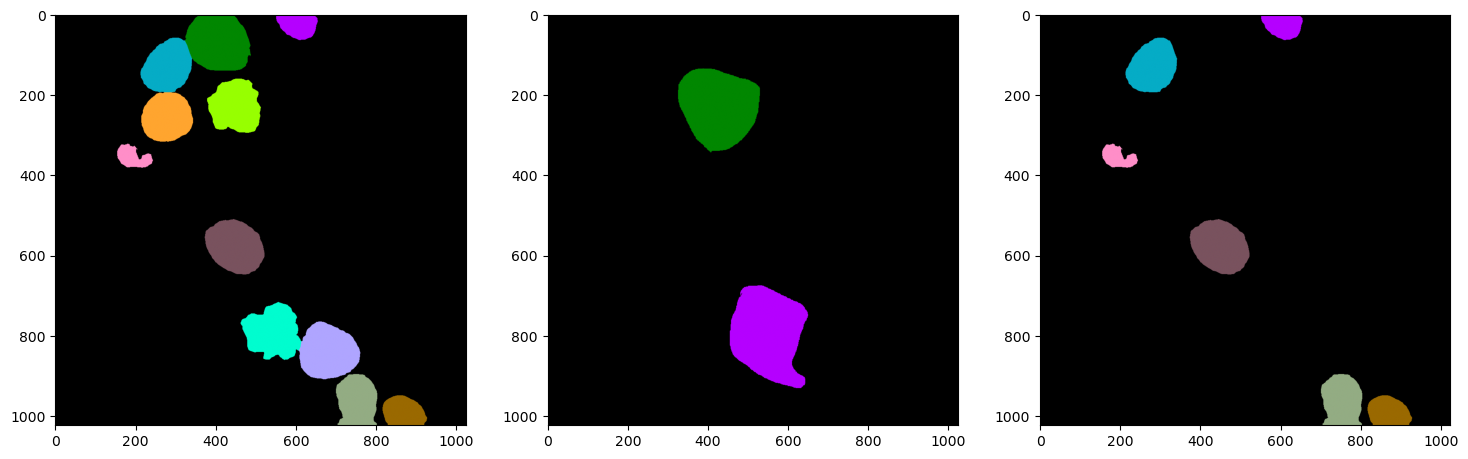

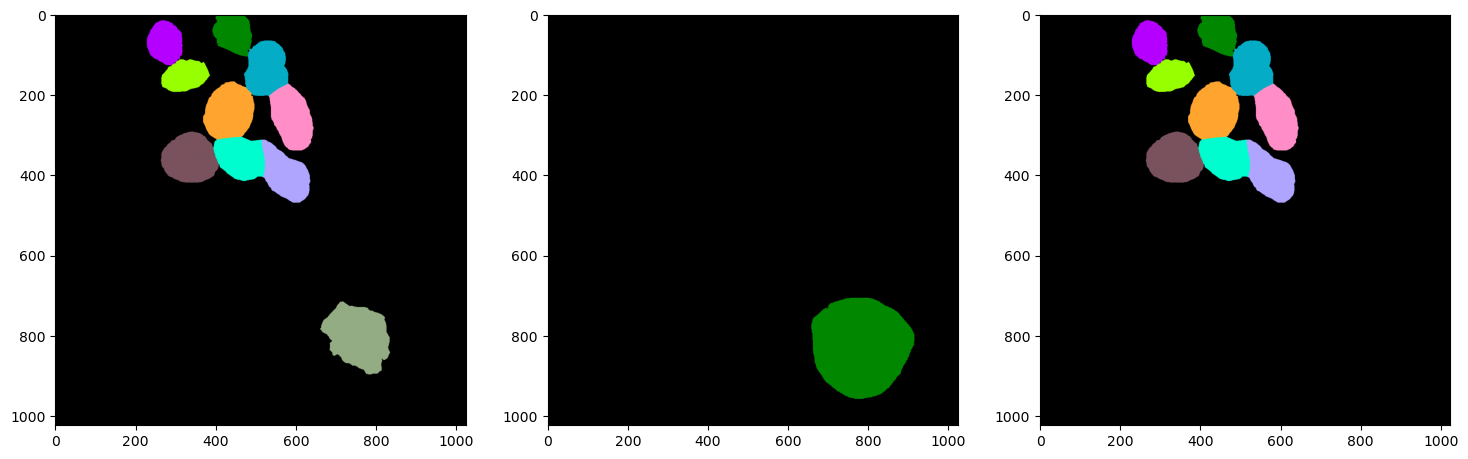

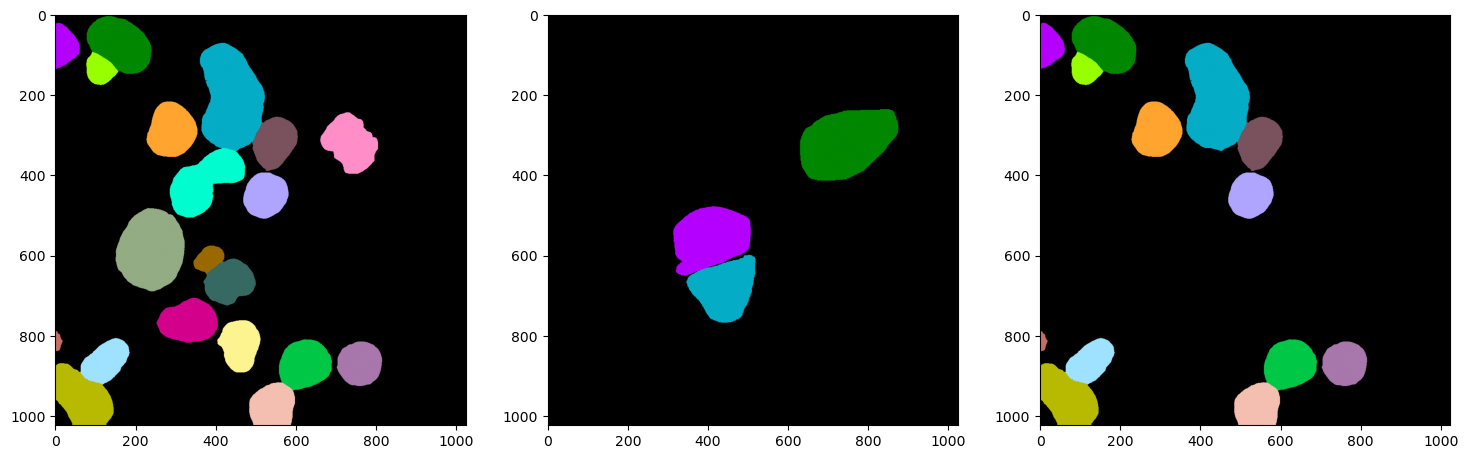

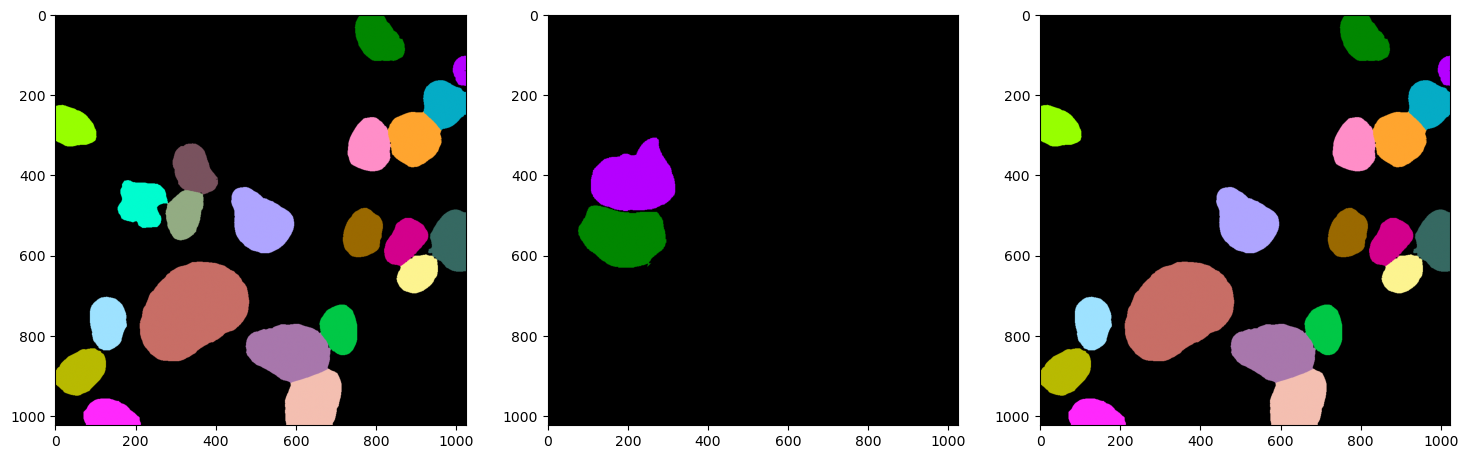

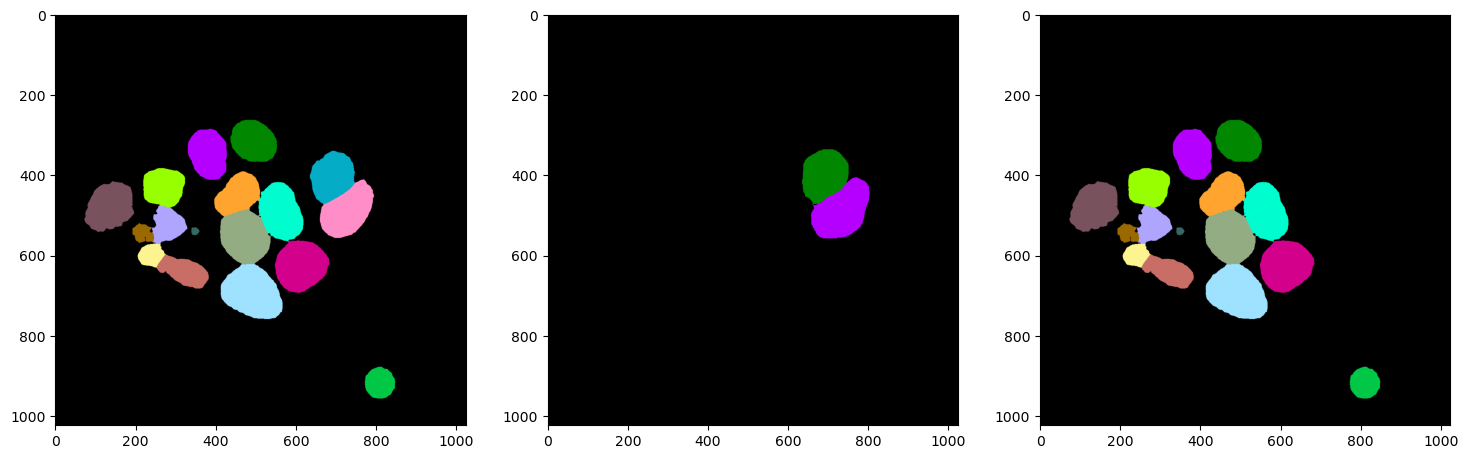

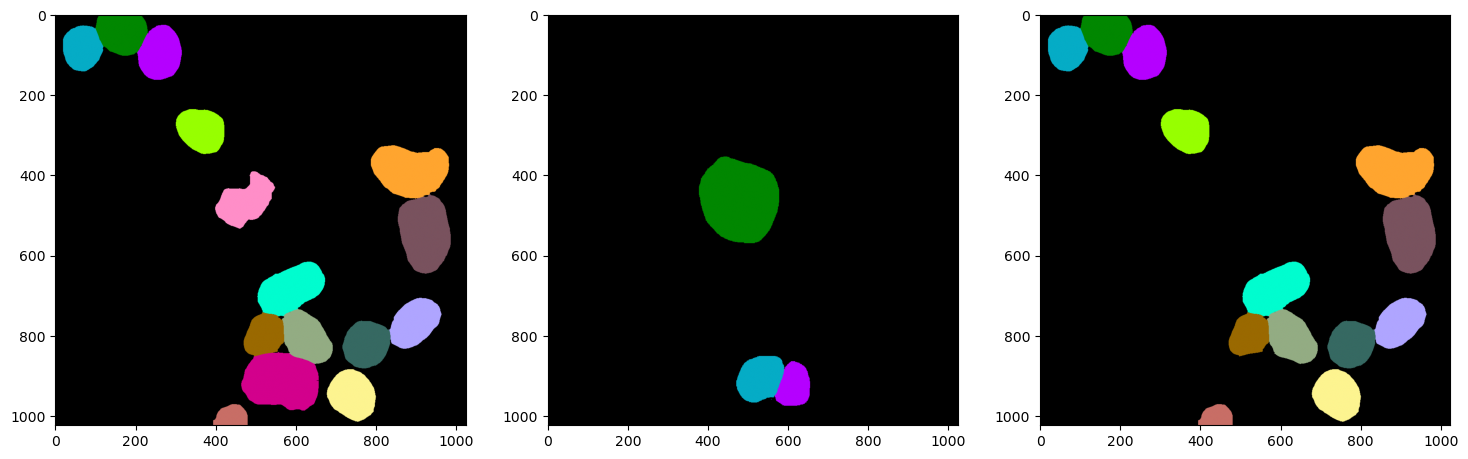

In [12]:
# left: segmentation of nuclei from Cellpose
# middle: manual segmentation of mitotic cells
# right: non-mitotic cells mask = after removal of any nuclei from left mask that overlap with the mitotic cells
for mask, mask_mito in zip(masks, masks_mito):
    remove_mitotic_cells(mask, mask_mito, colormap, show=True)